In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import matplotlib
# define plot dimensions
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12.,9.)

In [2]:
### axis_font = {'fontname':'Arial', 'size':'18'}    
title_font = {'fontname':'Arial', 'size':'32', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=28)
matplotlib.rc('ytick', labelsize=28)

In [3]:
baseline = '20170824.FCTfix-GM.A_WCYCL1850S.ne30_oECv3.anvil'
experiment = '20170904.test.A_WCYCL1850S.ne30_oECv3.anvil'

In [4]:
restartFile = sorted(glob.glob('/lcrc/group/acme/jwolfe/acme_scratch/'+baseline+'/run/mpaso.rst.000*'))
fn = restartFile[0]
meshBase = xr.open_dataset(fn)
restartFile = sorted(glob.glob('/lcrc/group/acme/jwolfe/acme_scratch/'+experiment+'/run/mpaso.rst.000*'))
fn = restartFile[0]
meshExp = xr.open_dataset(fn)

In [5]:
nzBase = meshBase.dims['nVertLevels']
nzExp = meshExp.dims['nVertLevels']

#create an area array that is nVertlevels in length
area1 = meshBase.areaCell.values
areaBase = np.copy(area1)

for i in range(nzBase-1):
    areaBase = np.vstack([areaBase,area1])
areaBase = areaBase.T

#create a cell mask to remove the -1e33 values
temp = meshBase.temperature[0,:,:].values
cellMaskBase = np.zeros_like(temp)
for i in range(nzBase):
    inds = np.where(temp[:,i]>-10)[0]
    cellMaskBase[inds,i] = 1.0

areavertBase = (areaBase*cellMaskBase).sum(axis=0)

#create an area array that is nVertlevels in length for Experiment run
area1 = meshExp.areaCell.values
areaExp = np.copy(area1)

for i in range(nzExp-1):
    areaExp = np.vstack([areaExp,area1])
areaExp = areaExp.T

#create a cell mask to remove the -1e33 values
temp = meshExp.temperature[0,:,:].values
cellMaskExp = np.zeros_like(temp)
for i in range(nzExp):
    inds = np.where(temp[:,i]>-10)[0]
    cellMaskExp[inds,i] = 1.0

areavertExp = (areaExp*cellMaskExp).sum(axis=0)

In [6]:
zvBase = meshBase.refBottomDepth.values
zvExp = meshExp.refBottomDepth.values
meshBase.close()
meshExp.close()

In [7]:
id700b = abs(zvBase-700).argmin()
id2000b = abs(zvBase-2000).argmin()

id700e = abs(zvExp-700).argmin()
id2000e = abs(zvExp-2000).argmin()

In [8]:
fnB = sorted(glob.glob('/lcrc/group/acme/jwolfe/acme_scratch/'+baseline+'/run/mpaso.am.timeSeriesStatsMonthly.00*'))
fnE = sorted(glob.glob('/lcrc/group/acme/jwolfe/acme_scratch/'+experiment+'/run/mpaso.hist.am.timeSeriesStatsMonthly.00*'))

In [9]:
#Find end of data set in both baseline and experiment
sp = fnB[-1].find('Monthly') + 8
yr = float(fnB[-1][sp:sp+4])
mon = float(fnB[-1][sp+5:sp+7])
if mon == 12:
    yrEndB = yr
else:
    yrEndB = yr - 1
    
sp = fnE[-1].find('Monthly') + 8
yr = float(fnE[-1][sp:sp+4])
mon = float(fnE[-1][sp+5:sp+7])
if mon == 12:
    yrEndE = yr
else:
    yrEndE = yr - 1
    
yrEnd = min(yrEndE, yrEndB)

In [10]:
nt = int(yrEnd)*12-1
fullB = np.zeros(nt)
sfcB = np.zeros(nt)
midB = np.zeros(nt)
botB = np.zeros(nt)
sstB = np.zeros(nt)

fullE = np.zeros(nt)
sfcE = np.zeros(nt)
midE = np.zeros(nt)
botE = np.zeros(nt)
sstE = np.zeros(nt)

rho = 1026
cp = 3996

endIndex = int(yrEnd)*12 - 1

for i in range(endIndex):
    ds = xr.open_dataset(fnB[i])
    heat = (ds.timeMonthly_avg_activeTracers_temperature[0,:,:]* \
                cellMaskBase*areaBase*ds.timeMonthly_avg_layerThickness[0,:,:]).sum(axis=0).values 
    fullB[i] = rho*cp*heat.sum()
    sfcB[i] = rho*cp*heat[:id700b].sum()
    midB[i] = rho*cp*heat[id700b:id2000b].sum()
    botB[i] = rho*cp*heat[id2000b:].sum()
    sstB[i] = (ds.timeMonthly_avg_activeTracers_temperature[0,:,0]*areaBase[:,0]* \
                   cellMaskBase[:,0]).sum(axis=0).values / areavertBase[0]
    ds.close()
    
    ds = xr.open_dataset(fnE[i])
    heat = (ds.timeMonthly_avg_activeTracers_temperature[0,:,:]* \
                cellMaskExp*areaExp*ds.timeMonthly_avg_layerThickness[0,:,:]).sum(axis=0).values 
    fullE[i] = rho*cp*heat.sum()
    sfcE[i] = rho*cp*heat[:id700e].sum()
    midE[i] = rho*cp*heat[id700e:id2000e].sum()
    botE[i] = rho*cp*heat[id2000e:].sum()
    sstE[i] = (ds.timeMonthly_avg_activeTracers_temperature[0,:,0]*areaExp[:,0]* \
                   cellMaskExp[:,0]).sum(axis=0).values / areavertExp[0]
    ds.close()
    print fullE[i], fullB[i]

2.01994475357e+25 1.98739284782e+25
2.02167826621e+25 1.98813434038e+25
2.02262514261e+25 1.98882885925e+25
2.02306956405e+25 1.98892160136e+25
2.02260278012e+25 1.98799310485e+25
2.02093880617e+25 1.98624835299e+25
2.01882237663e+25 1.98416047919e+25
2.0175397737e+25 1.98269454705e+25
2.01722206045e+25 1.982317882e+25
2.01798447171e+25 1.98266235958e+25
2.01897291056e+25 1.98347331637e+25
2.01990191819e+25 1.98445535028e+25
2.02112517856e+25 1.98528806665e+25
2.02250754772e+25 1.98614138387e+25
2.02374661289e+25 1.98673288138e+25
2.02416299842e+25 1.98682147711e+25
2.02355403624e+25 1.98600383529e+25
2.02214210145e+25 1.98451278289e+25
2.02020989841e+25 1.98244656581e+25
2.01878920087e+25 1.98095362863e+25
2.01846630322e+25 1.9804605647e+25
2.01905019041e+25 1.98087490812e+25
2.01992598629e+25 1.98141617934e+25
2.02108047928e+25 1.98231296063e+25
2.02234034587e+25 1.98328609656e+25
2.02363890318e+25 1.98427180806e+25
2.0247805336e+25 1.98501257584e+25
2.0252901112e+25 1.984904879e+25


In [11]:
nt = int(yrEnd)
fullYrB = np.zeros(nt)
sfcYrB = np.zeros(nt)
midYrB = np.zeros(nt)
botYrB = np.zeros(nt)
sstYrB = np.zeros(nt)

fullYrE = np.zeros(nt)
sfcYrE = np.zeros(nt)
midYrE = np.zeros(nt)
botYrE = np.zeros(nt)
sstYrE = np.zeros(nt)

for i in range(nt):
    fullYrB[i] = fullB[12*i:12*i+12].mean()
    sfcYrB[i] = sfcB[12*i:12*i+12].mean()
    midYrB[i] = midB[12*i:12*i+12].mean()
    botYrB[i] = botB[12*i:12*i+12].mean()
    sstYrB[i] = sstB[12*i:12*i+12].mean()
    
    fullYrE[i] = fullE[12*i:12*i+12].mean()
    sfcYrE[i] = sfcE[12*i:12*i+12].mean()
    midYrE[i] = midE[12*i:12*i+12].mean()
    botYrE[i] = botE[12*i:12*i+12].mean()
    sstYrE[i] = sstE[12*i:12*i+12].mean()

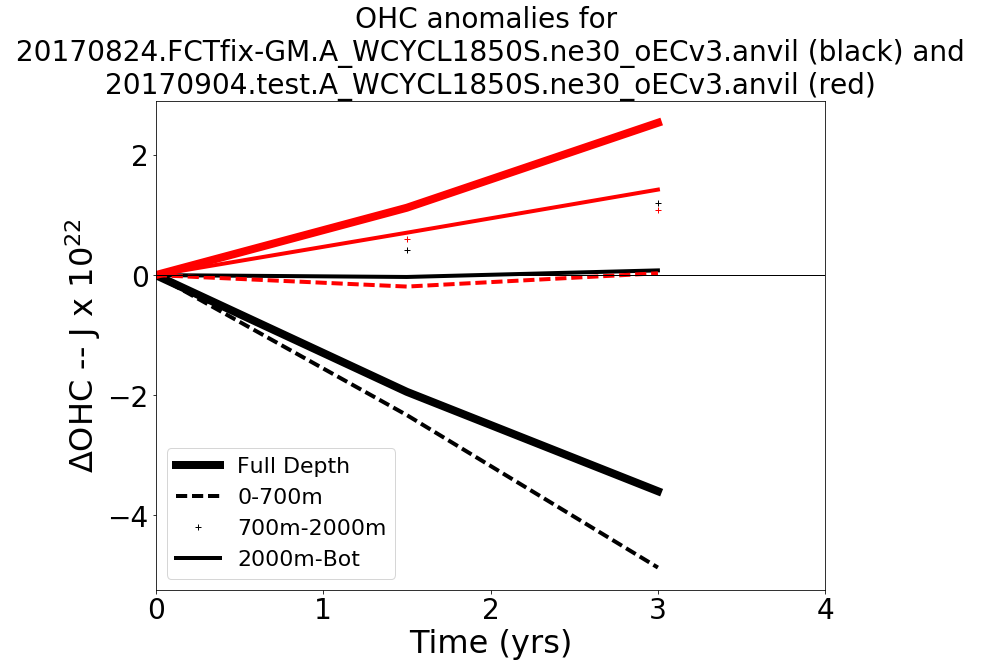

In [12]:
yr = np.linspace(0,nt-1,nt-1)
plt.plot(yr,(fullYrB[:-1]-fullYrB[0])*1e-22,'k',linewidth=8)
plt.plot(yr,(sfcYrB[:-1]-sfcYrB[0])*1e-22,'--k',linewidth=4)
plt.plot(yr,(midYrB[:-1]-midYrB[0])*1e-22,'+k',linewidth=4)
plt.plot(yr,(botYrB[:-1]-botYrB[0])*1e-22,'k',linewidth=4)

plt.plot(yr,(fullYrE[:-1]-fullYrE[0])*1e-22,'r',linewidth=8)
plt.plot(yr,(sfcYrE[:-1]-sfcYrE[0])*1e-22,'--r',linewidth=4)
plt.plot(yr,(midYrE[:-1]-midYrE[0])*1e-22,'+r',linewidth=4)
plt.plot(yr,(botYrE[:-1]-botYrE[0])*1e-22,'r',linewidth=4)

plt.plot(np.linspace(-1,100,3),np.zeros(3),'k',linewidth=1)
plt.xlim(0,nt)
plt.legend(['Full Depth','0-700m','700m-2000m','2000m-Bot'],loc='lower left',fontsize=22)
plt.xlabel('Time (yrs)',fontsize=32)
plt.ylabel(r'$\Delta$OHC -- J x 10$^{22}$',fontsize=32)
plt.title('OHC anomalies for \n '+baseline+' (black) and \n'+experiment+' (red)',fontsize=28)

In [13]:

yr = np.linspace(0,nt-1,nt-1)
plt.plot(yr,(sstYrB[:-1]),'k',linewidth=8)

plt.plot(yr,(sstYrE[:-1]),'r',linewidth=8)

plt.xlim(0,nt)
plt.xlabel('Time (yrs)',fontsize=32)
plt.ylabel(r'SST $^{o}$C',fontsize=32)
plt.title('Global average SST for \n'baseline +' (black) and \n'+experiment+' (red)',fontsize=28)

SyntaxError: invalid syntax (<ipython-input-13-cbe897e0156d>, line 10)